# COGS 108 - Final Project 

# Overview

Not all parks are of the same quality, and neither are the neighborhoods. Thus, I am interested in seeing if they are correlated. In this project I will be comparing the qualities between parks and the neighborhood it is in. For parks, I used public opinion as an indicator of quality, while for the neighborhoods I used the environmental health screening data. After conducting my analyes, it was concluded that the data does not suggest a correlation between the two qualities.


# Name & GitHub ID

- Name: Ai Hong
- GitHub Username: Quelynxyz

# Research Question

Is there a significant correlation between the Yelp ratings of a park and the quality of the neighborhood it is in? Specifically, the quality of the neighborhood determined by the environmental health factors.

## Background and Prior Work

Yelp is local business review and social networking site. The site contains reviews of locations, be it a park, school, or restaruant. The reviews are made by individual users who have been there to obtain a service or experience, and are on a one to five star rating system. Ratings are dependent on the individual's experiences, which can include objective measures of quality,  such as cleanliness, pollution, and  pricing. In one study, it was shown that yelp reviews were a reliable indicator of hospital quality, with higher reviews correlating to lower readmission rates[1].

As parks are a public recreational location for the members of the neighborhood, the quality of the neighborhood should determine the quality of the park as well. As such, it is reasonable to assume that the yelp ratings will correlate to the quality of the neighborhood it is in. Another study was able to find the correlation between gentrification of neighborhoods and yelp data[2], which implies that neighborhoods and yelp ratings should be correlated on some level.  

References :
- 1)https://media4.manhattan-institute.org/sites/default/files/R-PHYF-0417.pdf
- 2)https://www.hbs.edu/faculty/Publication%20Files/18-077_a0e9e3c7-eceb-4685-8d72-21e0f518b3f3.pdf

# Hypothesis


Since a lower quality park would leave a lesser impression on its visitor, I believe that there will be a significant positive correlation between the Yelp ratings of a park and the quality of the neighborhood it is in. A higher yelp rating will correlate to a higher neighborhood quality.

# Dataset(s)

#### California Environmental Health Screening Data
Link: https://data.ca.gov/dataset/calenviroscreen-2-0/resource/6d6a9a5c-9221-4fc5-9b00-35015ae65837 <br>
Number of observations: 8035<br>
Number of Variables: 54<br>

This dataset includes various pollution and health quality variables as well as the Census Tract they're taken from. I'll be using this one for determining quality ratings.

#### San Diego Parks Yelp Data
This dataset was kindly curated by Prof. Ellis, pulled off of  https://www.yelp.com/ <br>
Number of observations: 834<br>
Number of variables: 10 <br>

This dataset includes the names and coordinates of each park in San Diego, and the yelp rating given for it. I'll be using the coordinates and rating from this dataset.

To merge the two datasets, I'll use the yelp coordinates to convert the park location into a Census Tract. Each park will then have a census tract and the variable information for that census tract.

# Setup

In [18]:
#Import modules
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import censusgeocode
cg = censusgeocode.CensusGeocode(benchmark='Public_AR_Census2010', vintage='Census2010_Census2010')
import math

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [19]:
#Read Datasets

enviro_df = pd.read_csv("calenviroscreen-final-report.csv")
yelp_df = pd.read_csv("yelp_SD_parks.csv")

# Data Cleaning

Here we will be extracting the relevant columns from the datasets that we are interested in. For the environmental data, we need the census tract and then the variables used to calculate pollution (ignoring percentile), as well as poverty. For the yelp reviews, we will keep the park names for reference, and extract the ratings and coordinates. The coordinates will be used to find the Census tract of that park. Then we will drop any null values, and merge the dataframes based on the Census Tract.

In [20]:
#Extract columns we are interested in
enviro_df = enviro_df[['Census Tract', 'Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water',
                      'Pesticides', 'Tox. Release', 'Traffic', 'Groundwater Threats', 'Haz. Waste', 
                      'Imp. Water Bodies', 'Solid Waste', 'Poverty']]


In [21]:
yelp_df = yelp_df[['name', 'rating', 'longitude', 'latitude']]

In [22]:
# Drop any NA values
yelp_df = yelp_df.dropna()
enviro_df = enviro_df.dropna()

In [23]:
#Convert Yelp locations to Census Tract. Returns Tract number
def get_tract(long, lat):
    tract=[]
    for i in np.arange(len(long)):
        try:
            geoid = cg.coordinates(x = long[i], y = lat[i])['Census Tracts'][0]['GEOID']
            tract.append(geoid)
        except:
            tract.append(np.nan)
            
    return tract

In [24]:
tracts = get_tract(yelp_df['longitude'],yelp_df['latitude'])

In [25]:
#add the new tracts into the dataframe, drop null values, merge with environmental data based on Tract number
yelp_df['Census Tract'] = tracts
yelp_df.dropna(subset = ['Census Tract'], inplace=True)
yelp_df['Census Tract'] = yelp_df['Census Tract'].astype(int)

full_df = pd.merge(yelp_df, enviro_df, on = 'Census Tract')

In [26]:
full_df = full_df.dropna()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 0 to 741
Data columns (total 17 columns):
name                   742 non-null object
rating                 742 non-null float64
longitude              742 non-null float64
latitude               742 non-null float64
Census Tract           742 non-null int64
Ozone                  742 non-null float64
PM2.5                  742 non-null float64
Diesel PM              742 non-null float64
Drinking Water         742 non-null float64
Pesticides             742 non-null float64
Tox. Release           742 non-null float64
Traffic                742 non-null float64
Groundwater Threats    742 non-null float64
Haz. Waste             742 non-null float64
Imp. Water Bodies      742 non-null int64
Solid Waste            742 non-null float64
Poverty                742 non-null float64
dtypes: float64(14), int64(2), object(1)
memory usage: 104.3+ KB


# Data Analysis & Results

Now we make a dataset with the variables used to determine quality. Because quality is relative, we will be first compressing the multiple variables into two principal components, and then group the results using k-means clustering. Because all of the variables have a negative impact at a higher level, the clusters will be at a lower quality moving from left to right.

In [27]:
df = full_df[[ 'Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Pesticides', 
                'Tox. Release', 'Traffic', 'Groundwater Threats', 'Haz. Waste', 
                'Imp. Water Bodies', 'Solid Waste', 'Poverty']]

#Standardize data
df = df.apply(preprocessing.scale)

#Extract Values into matrix and Transpose
df = df.values.T
df.shape
count = df.shape[1]

shape of mean matrix = (12, 742)
Confirming covariance matrix shape: (12, 12)
Confirming Vectors matrix shape: (12, 12)


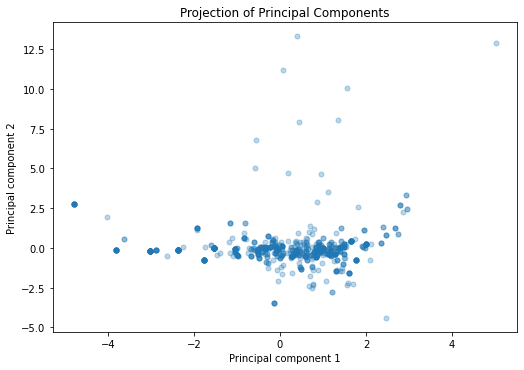

In [28]:
#PCA TIME

## Find Means of Data
mean12d = np.mean(df, 1)

##Tile it
mean12d = np.tile(mean12d, (count,1)).T
print('shape of mean matrix = ' + str(mean12d.shape))

#Find z
z = np.subtract(df,mean12d)

#Calculate Covariance
C = np.matmul(z,z.T)/(count -1 )
C = np.array(C, dtype='float')

#confirm 12 x12 covariance matrix
print('Confirming covariance matrix shape: ' + str(C.shape))

##Calculate eigenvectors
D,V = np.linalg.eig(C)

#sort Vectors
idx = D.argsort()[::-1]
Vs = V[:,idx]
print('Confirming Vectors matrix shape: ' +str(Vs.shape))

#project onto 2 components, df2 stores those 2 components as x and y 
proj = np.matmul(Vs[:,0:2].T,z)
proj = np.array(proj, dtype = 'float')
df2 = pd.DataFrame(dict(x= proj[0,:], y= proj[1,:], label=full_df['rating'].astype(int)))

# Plot
fig, ax = plt.subplots()
ax.plot(proj[0,:], proj[1,:], marker='o', linestyle='', ms=5, alpha=.3)
ax.set_title('Projection of Principal Components')
ax.set_ylabel('Principal component 2')
ax.set_xlabel('Principal component 1')
plt.subplots_adjust(right = 1.2, top = 1.2)
plt.show()

We see that the PCA distribution has the most consistent variation across component 1. Most of the points are concentrated in a  large cluster in the center. We now assume the principal components work in a similar fashion as the variables they compiled from, with a higher value indicating a more negative impact. Since principal component 1 accounts for more of the variability than component 2, the later clusters will be rated horizontally.

Now we begin clustering. As yelp ratings range from integers 1 to 5, we will use k=5 to parallel that. This will result in 5 clusters, of which we will give a rating from 1 to 5 based on their presence from left to right

In [29]:
#Make cluster dataframe based on the component projections
clust = df2.values[:,0:2]
print(clust.shape)

(742, 2)


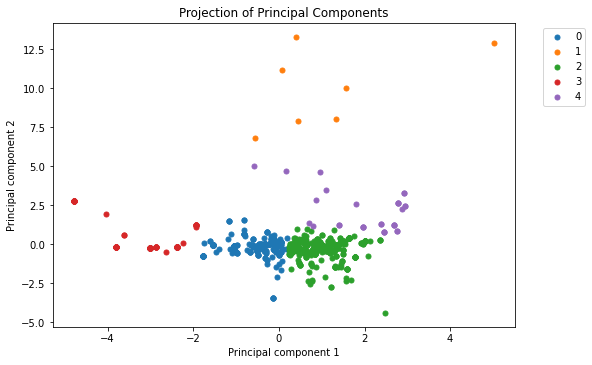

In [30]:
##CLUSTER DATA with k = 5

kmeans = KMeans(n_clusters = 5)
y_kmeans = kmeans.fit_predict(clust)
kmeans.cluster_centers_

kmeans_df = pd.DataFrame(dict(x= df2['x'], y = df2['y'], label=y_kmeans))
kgroups = kmeans_df.groupby('label')

# Plot
fig, comp = plt.subplots()

for val, group in kgroups:
    comp.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=val)

comp.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#label plots
comp.set_title('Projection of Principal Components')
comp.set_ylabel('Principal component 2')
comp.set_xlabel('Principal component 1')

plt.tight_layout()
plt.subplots_adjust(right = 1.2, top = 1.2)
plt.show()

The points in the PCA have now been clustered into 5 groups, and we see the plotted distributions of those groups above. Now we can assign each group a rating from 1 to 5. Going by the colors from left to right. Red/5 --> Blue/4 --> Green/3 --> purple/2 --> yellow/1
- group 0 = 4 
- group 1 = 1
- group 2 = 3
- group 3 = 5
- group 4 = 2

In [31]:
ratings = y_kmeans.copy()
for x in np.arange(len(y_kmeans)):
    if y_kmeans[x] == 0:
        ratings[x] = 4
        
    elif y_kmeans[x] == 1:
        ratings[x] = 1
           
    elif y_kmeans[x] == 2:
        ratings[x] = 3
           
    elif y_kmeans[x] == 3:
        ratings[x] = 5
           
    elif y_kmeans[x] == 4:
        ratings[x] = 2
    else:
        next

full_df['Quality'] = ratings.T


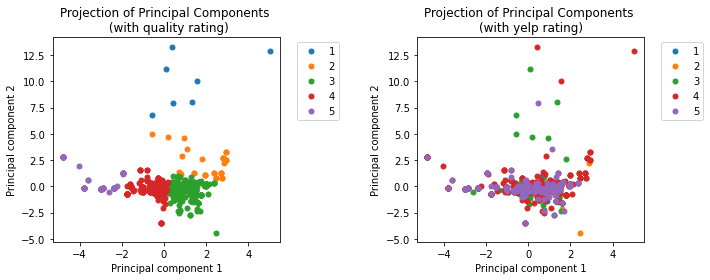

In [44]:
fig, comp = plt.subplots(1, 2)

df2 = pd.DataFrame(dict(x= proj[0,:], y= proj[1,:], label=full_df['rating'].astype(int)))
groups = df2.groupby('label')

quality_df = pd.DataFrame(dict(x= df2['x'], y = df2['y'], label= full_df['Quality']))
qgroups = quality_df.groupby('label')

for val, group in qgroups:
    comp[0].plot(group.x, group.y, marker='o', linestyle='', ms=5, label=val)

comp[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

for name, group in groups:
    comp[1].plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name)
comp[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

comp[0].set_title('Projection of Principal Components \n (with quality rating)')
comp[0].set_ylabel('Principal component 2')
comp[0].set_xlabel('Principal component 1')
comp[1].set_title('Projection of Principal Components \n(with yelp rating)')
comp[1].set_ylabel('Principal component 2')
comp[1].set_xlabel('Principal component 1')

plt.tight_layout()
plt.subplots_adjust(right = 1.5, wspace=.6)

We now have 2 graphs, one with the new quality ratings and one with the yelp ratings. The yelp ratings had their decimals dropped so the two ratings would have the same range. However, we see that each value of the yelp ratings have much more variability compared to the quality ratings. This indicates that the k-means clustering groupings may have been inappropriate. 

Below we will compare the distributions of the ratings.

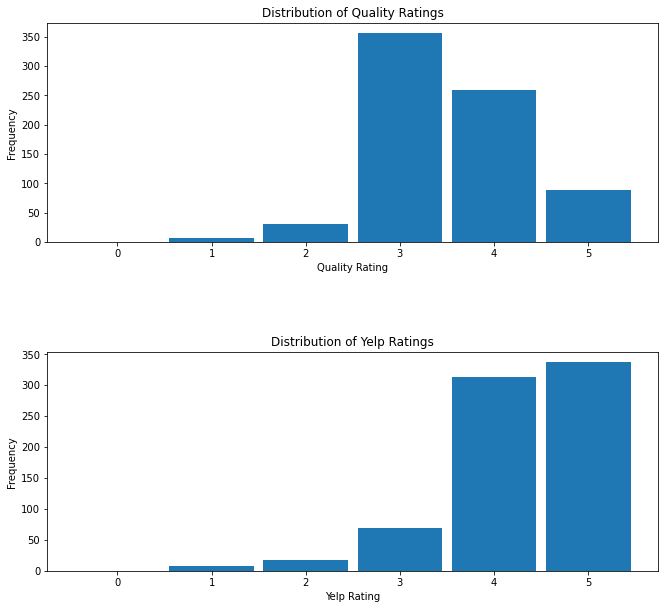

In [49]:
fig, hists = plt.subplots(2,1)
hists[0].hist( full_df['Quality'], bins= np.arange(7) -.5, rwidth= .9) 
hists[1].hist( full_df['rating'], bins = np.arange(7) -.5, rwidth= .9) 
fig.tight_layout()
plt.subplots_adjust(right = 1.5, top = 2 ,hspace=.5)

hists[0].set_title('Distribution of Quality Ratings')
hists[0].set_ylabel('Frequency')
hists[0].set_xlabel('Quality Rating')
hists[1].set_title('Distribution of Yelp Ratings')
hists[1].set_ylabel('Frequency')
hists[1].set_xlabel('Yelp Rating')

plt.show()

The distributions of the ratings are slightly similar. However, we still need to check to see if the ratings are actually correlated.

In [67]:
#Find if there is a correlation
yelp = full_df['rating'].astype(int).values.T
compare = full_df['Quality'].values.T

r = np.corrcoef(yelp, compare)
print(r)

[[ 1.         -0.04441535]
 [-0.04441535  1.        ]]


The quality ratings and the yelp ratings have a correlation coefficient of r = -.04, which means there is no linear relationship.

# Ethics & Privacy

The data used in this project are all publicly accessible and do not contain personal information. As such there are no privacy concerns. However, there are biases in the data. The yelp review of the parks would be made by visitors of the parks, who would most likely live in that area. As such, they would have a bias for their own neighborhoods, or that the visitors of the parks are only a subset of the possible demographics of the neighborhood. It would thus be an inaccurate representation of the whole community's opinion. There is no way to address this however, as the yelp reviewers have the option to be anonymous through a pseudonym, and searching for their personal information is heavily unethical. 

# Conclusion & Discussion

After performing PCA on the data and clustering them into groups, and assigning them a quality scale, the resulting quality ratings did not correlate with the yelp rating. This was due to yelp ratings having a larger variance than the clustered groups. The groups were clustered based on distance between each point, and the quality was determined by placement from left to right. There are several limitations to this. 

For starters, there are actually 270 unique census tracts, compared to almost triple the amount of parks. Despite that, the amount of data points that underwent PCA was based on the amount of parks instead of the unique census tracts that the variables were based on. As such, the repetitions of data would have altered the resulting clustering possibilities. Another limitation would be that there is no way to determine the actual correspondence of quality between the groups. The resulting numbers were technically categorical, as were the yelp ratings. However, the categories were measuring different things. Perhaps K-means clustering was not appropriate as the yelp ratings couldn't be clustered by distance from each other like the quality ratings. 

The final problem this project faced was running the code. To convert the coordinates to the corresponding Census Tract, I imported a module that had the corresponding method. However, when I ran the code several times, the amount of coordinates that could be traslated were all different, with the error being that the module couldn't parse through the Census results. Perhaps it was my spotty internet, or the module itself, but it definitely altered the resulting PCA plot, even flipping it. 

It was disappointing that a correlation between the two ratings could not have been found. If they were correlated, then that would imply that improving the quality of neighborhoods would improve the ratings of the parks. As such, they would have more people visit, which would motivate the city council to maintain it more or even renovate it, which would in turn improve the quality of the neighborhoods. I believe a different analysis approach could possibly find the correlation. 